In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import flatten_dict
import pytorch_lightning as pl
from omegaconf import OmegaConf
import torch
from dabs.src.systems import viewmaker, viewmaker_original
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as image
import torchvision
from IPython import display
from viewmaker.src.systems.image_systems.utils import heatmap_of_view_effect
from torchvision.utils import make_grid
import pandas as pd
%matplotlib inline

In [2]:
import torchvision.transforms.functional as F

def show(imgs,**fig_kwr):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False,**fig_kwr)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [3]:
config = OmegaConf.load('/workspace/dabs/conf/traffic.yaml')
config.debug = True
config.dataset = OmegaConf.load('/workspace/dabs/conf/dataset/traffic_sign_small.yaml')
config.model = OmegaConf.load('/workspace/dabs/conf/model/traffic_model.yaml')

config.dataset.batch_size = 64

pl.seed_everything(config.trainer.seed)

system = viewmaker_original.TrafficViewMaker(config)
system.setup('')
system.load_state_dict(torch.load('/workspace/dabs/exp/models/traffic_gan/presentation.ckpt')['state_dict'],strict=False)

system.eval()

Global seed set to 0


31367 train examples, 7842 val examples


TrafficViewMaker(
  (model): TrafficModel(
    (embed_modules): ModuleList()
    (traffic_model): Net(
      (conv1): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1))
      (bn1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1))
      (bn2): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(150, 250, kernel_size=(3, 3), stride=(1, 1))
      (bn3): BatchNorm2d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_drop): Dropout2d(p=0.5, inplace=False)
      (fc1): Linear(in_features=1000, out_features=350, bias=True)
      (fc2): Linear(in_features=350, out_features=43, bias=True)
      (localization): Sequential(
        (0): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): ReLU(inplace=True)
        (3): Conv2

## Explore data

In [5]:
data = {
    'image' : [],#list(img.numpy()),
    'class' : []#list(labels.numpy())
}

loader = system.val_dataloader()
i=0
for index , img , labels in loader:
    if i < 100:
        data['image'] += list(img.numpy())
        data['class'] += list(labels.numpy())
    i+=1

df = pd.DataFrame(data = data)


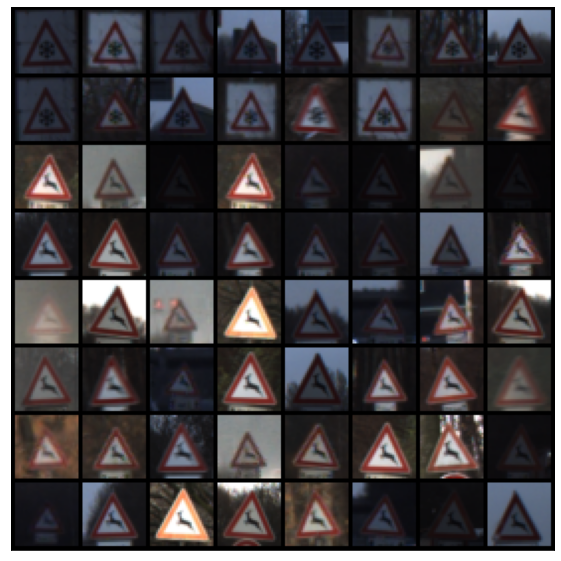

In [6]:
grid = make_grid(img)
show(grid,figsize=(10,10))

In [27]:
# system.model.foward([system.normalize(img)])
system.model.traffic_model.forward_original(system.normalize(img)).max(1, keepdim=True)[1].flatten() == labels

tensor(64)

In [8]:
rep = df.groupby('class').head(8).sort_values('class')

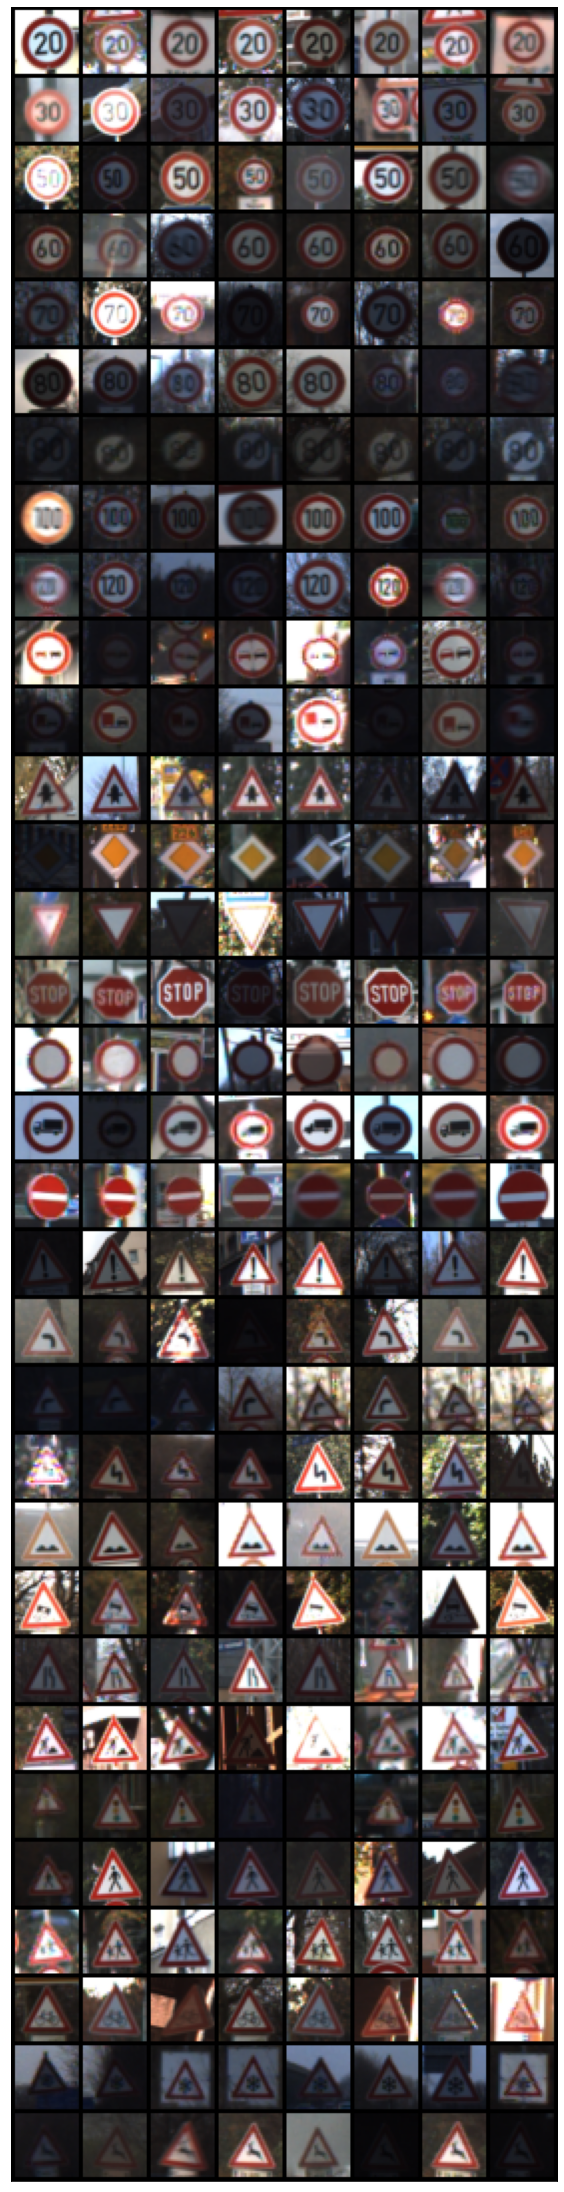

In [9]:
grid = make_grid(torch.from_numpy(np.stack(rep['image'])))
show(grid,figsize=(10,40))

In [63]:
# import seaborn as sns
# sns.histplot(df['class'],discrete=True)

## Explore views

31367 train examples, 7842 val examples


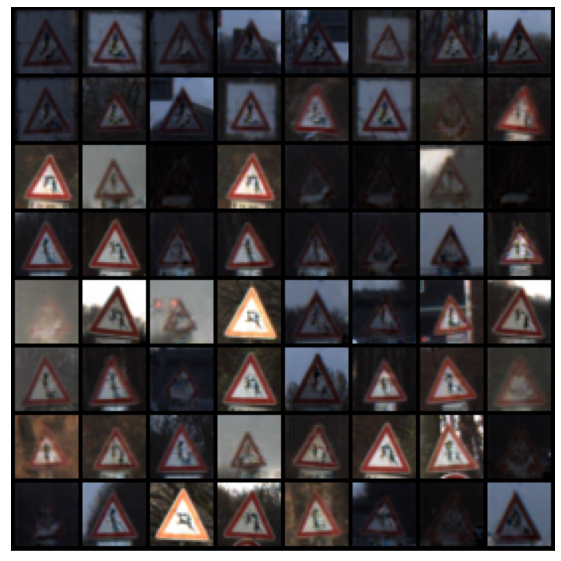

In [11]:
system = viewmaker_original.TrafficViewMaker(config)
system.setup('')
path = '/workspace/dabs/exp/models/traffic_gan_presentation/epoch=163-step=60000.ckpt'
path = '/workspace/dabs/exp/models/traffic_gan/presentation.ckpt'
system.load_state_dict(torch.load(path)['state_dict'],strict=False)

# system.eval()
x=0
views1, unnormalized_view1 = system.view(img, True)
grid = make_grid(unnormalized_view1)
show(torch.clamp(grid, 0, 1.0),figsize=(10,10))

In [17]:
view_rep = df.groupby('class').head(5).sort_values('class')
src = torch.from_numpy(np.stack(view_rep['image']))

In [18]:
# views = []
# for i in range(5):
views1, unnormalized_view1 = system.view(src, True)
unnormalized_view1 = torch.clamp(unnormalized_view1, 0, 1.0)
# con = torch.concat([src.unsqueeze(1)]+[v.unsqueeze(1) for v in views],dim=1)


In [21]:
con = torch.concat([src.unsqueeze(1)]+[unnormalized_view1.unsqueeze(1)],dim=1)


In [30]:
classes_acc = {}
for i,c in enumerate(view_rep['class']):
    res = system.model.traffic_model.forward_original(system.normalize(con[i,1:])).max(1, keepdim=True)[1].flatten()
    classes_acc[c] =  {'acc': (res == c).sum() / len(res) , 'res' : res}
    
total_acc = np.mean([c['acc'].item() for c in classes_acc.values()])
print(total_acc)

0.1875


In [23]:
[c for c in classes_acc.values() if c['acc'].item() > 0.5]

[{'acc': tensor(1.), 'res': tensor([10])},
 {'acc': tensor(1.), 'res': tensor([12])},
 {'acc': tensor(1.), 'res': tensor([16])},
 {'acc': tensor(1.), 'res': tensor([17])},
 {'acc': tensor(1.), 'res': tensor([18])},
 {'acc': tensor(1.), 'res': tensor([21])}]

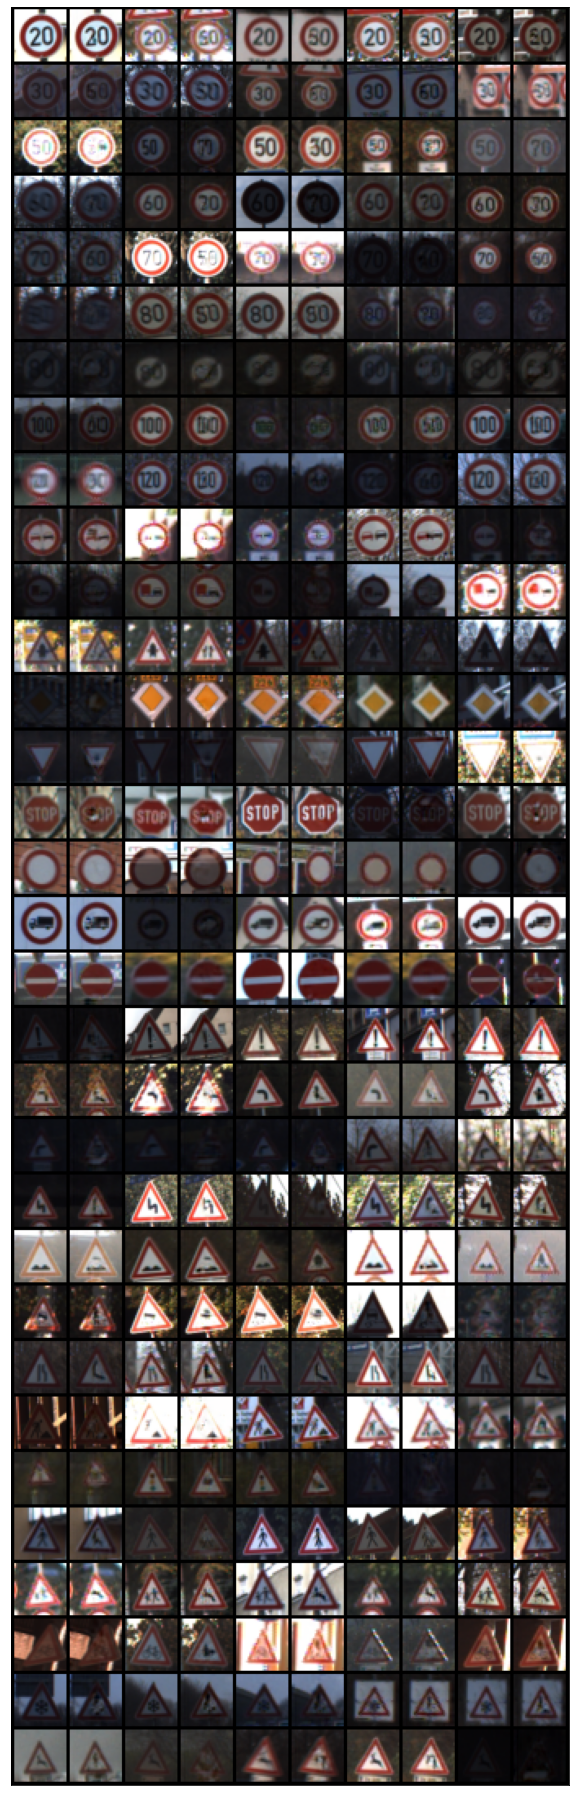

In [25]:
grid = make_grid(con[:,:10].reshape(-1,3,32,32),nrow=10)
show(grid,figsize=(10,40))

## evaluation on val set

In [36]:
from tqdm import tqdm

In [37]:
loader = system.val_dataloader()
i=0
correct_src = 0
correct_views = 0
total_imgs = 0
for index , img , labels in tqdm(loader):
    correct_src += (system.model.traffic_model.forward_original(system.normalize(img)).max(1, keepdim=True)[1].flatten() == labels).sum()
    views1, unnormalized_view1 = system.view(img, True)
    unnormalized_view1 = torch.clamp(unnormalized_view1, 0, 1.0)
    correct_views += (system.model.traffic_model.forward_original(system.normalize(unnormalized_view1)).max(1, keepdim=True)[1].flatten() == labels).sum()
    total_imgs += img.shape[0]

print((correct_src+0.0)/total_imgs ,(correct_views+0.0)/total_imgs ,total_imgs )

100%|██████████| 122/122 [00:17<00:00,  6.90it/s]

tensor(0.9525) tensor(0.2409) 7808


## create views dataset